In [78]:
import ale_py
import gymnasium as gym

gym.register_envs(ale_py)

import equinox as eqx
from einops import rearrange

import jax
from jax import numpy as jnp, random as jr, vmap

from matplotlib import pyplot as plt

In [96]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array", frameskip=1)
env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=False, screen_size=(64, 64))

buffer = []
max_steps = 1000
obs, info = env.reset()
episode_over, steps = False, 0
while not episode_over and steps < max_steps:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    buffer.append(obs)
    
    episode_over = terminated or truncated
    steps = steps + 1
env.close()

buffer = jnp.array(buffer) / 255.0
print(buffer.shape) 

(949, 64, 64, 3)


In [97]:
def _squared_cdist(a: jnp.ndarray, b: jnp.ndarray) -> jnp.ndarray:
    a2 = jnp.sum(a**2, axis=-1, keepdims=True)
    b2 = jnp.sum(b**2, axis=-1, keepdims=True)
    ab = a @ b.T
    return jnp.clip(a2 - 2 * ab + b2.T, a_min=0, a_max=None)

C = 3
patch_size = 8
max_codes = 1000
code_dim = patch_size * patch_size * C
threshold = 0.1

codebook = jnp.zeros((max_codes, code_dim))
codebook_idx = 0

num_images = buffer.shape[0]
for img_idx in range(num_images):
    image = buffer[img_idx]

    patches = rearrange(
        image, "(h ph) (w pw) c -> (h w) (ph pw c)", ph=patch_size, pw=patch_size
    )
    for patch in patches:
        if codebook_idx == 0:
            codebook = codebook.at[codebook_idx].set(patch)
            codebook_idx += 1
        else:
            valid_codes = codebook[:codebook_idx]
            dists = _squared_cdist(patch[None, :], valid_codes)

            if not jnp.any(dists < threshold):
                if codebook_idx < max_codes:
                    codebook = codebook.at[codebook_idx].set(patch)
                    codebook_idx += 1

num_codes_found = int(codebook_idx)
print(f"Found {num_codes_found} codes")

Found 378 codes


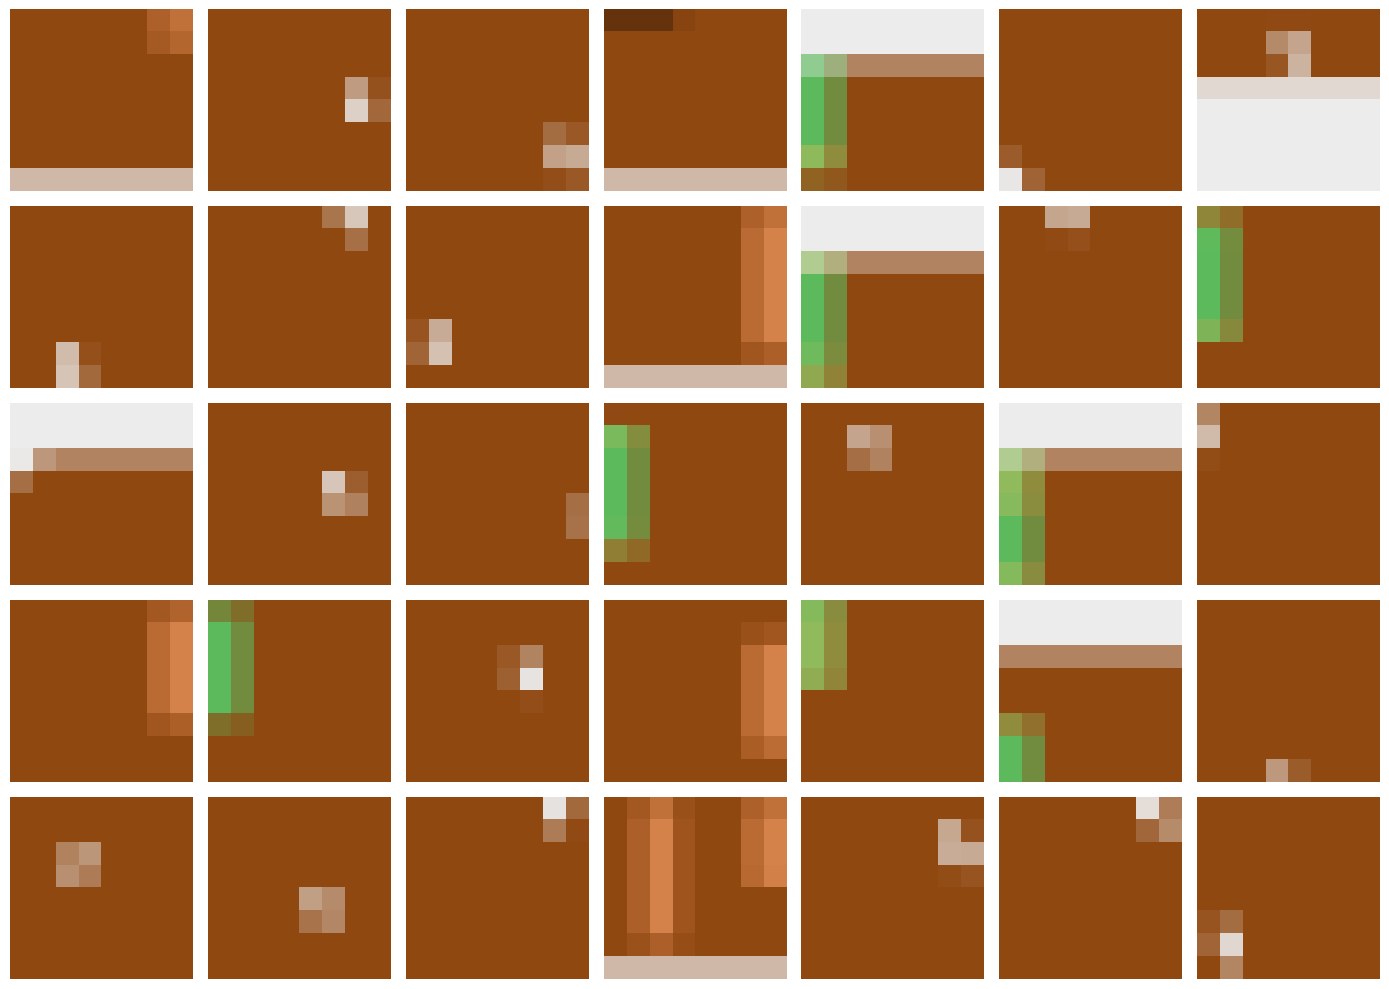

In [98]:
key = jr.PRNGKey(0)
num_show = min(num_codes_found, 100)
chosen_indices = jr.choice(key, num_codes_found, shape=(num_show,), replace=False)
selected_codes = np.array(codebook[chosen_indices]) 

patch_images = selected_codes.reshape(-1, patch_size, patch_size, C)

rows = 5
cols = (n_show + rows - 1) // rows
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flat
for ax, patch_img in zip(axes, patch_images):
    ax.imshow(patch_img)
    ax.axis("off")
for ax in axes[len(patch_images):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [99]:
def get_code_indices(image, codebook, num_codes, patch_size):
    patches = rearrange(
        image, "(h ph) (w pw) c -> (h w) (ph pw c)", ph=patch_size, pw=patch_size
    )
    valid_codes = codebook[:num_codes]
    dists = _squared_cdist(patches, valid_codes)
    indices = jnp.argmin(dists, axis=1)
    return indices.reshape((image.shape[0] // patch_size, image.shape[1] // patch_size))


def reconstruct_image_from_indices(indices, codebook, num_codes, patch_size, channels):
    valid_codes = codebook[:num_codes]
    patches_flat = valid_codes[indices.reshape(-1)]
    patches_recon = patches_flat.reshape(
        indices.shape[0], indices.shape[1], patch_size, patch_size, channels
    )
    return rearrange(patches_recon, "h w ph pw c -> (h ph) (w pw) c")


image_buffer = []
reconstruction_buffer = []
obs, info = env.reset()
steps = 0
done = False
while not done and steps < max_steps:
    action = env.action_space.sample()
    image, reward, terminated, truncated, info = env.step(action)
    image = image / 255.0
    image_buffer.append(image)
    inds = get_code_indices(image, codebook, codebook_idx, patch_size)
    recon = reconstruct_image_from_indices(inds, codebook, codebook_idx, patch_size, C)
    reconstruction_buffer.append(recon)
    done = terminated or truncated
    steps += 1
env.close()

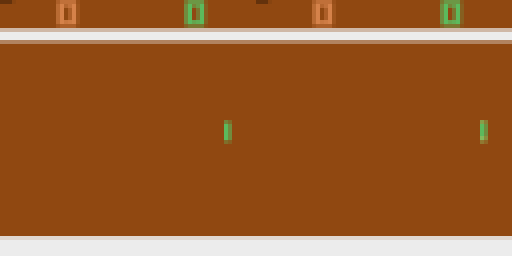

In [100]:
from PIL import Image
from IPython.display import Image as IPyImage, display

resize_factor = 4

frames = []
for i in range(len(image_buffer)):
    left = np.array(image_buffer[i])
    right = np.array(reconstruction_buffer[i])

    if left.max() <= 1.0:
        left = (left * 255).astype(np.uint8)
    if right.max() <= 1.0:
        right = (right * 255).astype(np.uint8)

    im_left = Image.fromarray(left)
    im_right = Image.fromarray(right)

    new_size = (im_left.width * resize_factor, im_left.height * resize_factor)
    im_left = im_left.resize(new_size, Image.NEAREST)
    im_right = im_right.resize(new_size, Image.NEAREST)

    new_im = Image.new("RGB", (im_left.width + im_right.width, im_left.height))
    new_im.paste(im_left, (0, 0))
    new_im.paste(im_right, (im_left.width, 0))

    frames.append(new_im)

gif_filename = "reconstruction.gif"
frames[0].save(
    gif_filename,
    format="GIF",
    append_images=frames[1:],
    save_all=True,
    duration=200,
    loop=0,
)
display(IPyImage(filename=gif_filename))